# augmentation을 적용한 함수 dl모델을 제작

데이터 증강 함수
- A.Resize(height=256, width=256) : 사이즈 변경
- A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) : 이미지 픽셀 정규화
- A.CoarseDropout(max_holes=16, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16) : 픽셀 드롭아웃(구멍뚫기)
- A.Rotate(limit=(115, 115), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0) : 비율 유지하여 회전, 빈공간 흰색
- A.VerticalFlip(always_apply=False, p=0.5) : 좌우반전
- A.HorizontalFlip(always_apply=False, p=1.0) : 상하반전
- A.Blur(always_apply=True, p=1.0, blur_limit=(3, 7)) : 블러
- A.GaussNoise(always_apply=False, p=1.0, var_limit=(10.0, 50.0)) : 가우시안, 되는지 의문
- A.Downscale(always_apply=False, p=1.0, scale_min=0.35, scale_max=0.35, interpolation=0) : 픽셀다운, 모자이크
- 믹스 추가필요

증강이 너무 심한것으로 확인하고 약화시켜봄
- 가설 3 : 이미지의 사이즈를 키우면 노이즈의 영향이 줄어 더 좋은 성능을 보일 것이다.

In [1]:
# # wandb 연결
# import wandb
# import random  # 데모 스크립트용

In [4]:
# wandb.login()

True

In [ ]:
# args = {
#     'learning_rate' : learning_rate,
#     'epochs': epochs,
#     'batch_size' : batch_size
# }
# wandb.config.update(args)

In [11]:
# run = wandb.init(
#     # Set the project where this run will be logged
#     project="연습",
#     # Track hyperparameters and run metadata
#     config={
#         "learning_rate": 0.01,
#         "epochs": 50,
#     },
# )
# lr = 0.01
# offset = random.random() / 5
# print(f"lr: {lr}")

# # 트레이닝 run을 시뮬레이션
# for epoch in range(2, 5):
#     acc = 1 - 2**-epoch - random.random() / epoch - offset
#     loss = 2**-epoch + random.random() / epoch + offset
#     print(f"epoch={epoch}, accuracy={acc}, loss={loss}")
#     wandb.log({"accuracy": acc, "loss": loss})

# # run.log_code()

lr: 0.01
epoch=2, accuracy=0.5833887672517647, loss=0.6732414707558301
epoch=3, accuracy=0.594427640518539, loss=0.4773990529087723
epoch=4, accuracy=0.8607594281688221, loss=0.22298631859514145


In [19]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

import cv2
import matplotlib.pyplot as plt

from itertools import combinations

In [20]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [21]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target
    

In [22]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, vaild_loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []
    vaild_preds_list = []
    vaild_target_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.float().to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    # vaildation set predict
    model.eval()
    for image, target in tqdm(vaild_loader):
        image = image.float().to(device)

        with torch.no_grad():
            preds = model(image)
        vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        vaild_target_list.extend(target.detach().cpu().numpy())
    vaild_acc = accuracy_score(vaild_target_list, vaild_preds_list)
    vaild_f1 = f1_score(vaild_target_list, vaild_preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
        "vaild_acc": vaild_acc,
        "vaild_f1": vaild_f1,
    }

    return ret

In [23]:
# vaild_preds_list = []
# vaild_target_list = []

# model.eval()
# for image, target in tqdm(vaild_loader):
#     image = image.float().to(device)

#     with torch.no_grad():
#         preds = model(image)
#     vaild_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
#     vaild_target_list.extend(target.detach().cpu().numpy())
# vaild_acc = accuracy_score(vaild_target_list, preds_list)
# vaild_f1 = f1_score(vaild_target_list, preds_list, average='macro')

In [26]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../datasets_fin/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 256 * 2
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0

- 일단 단일 augmentation들로 확인
- 성능향상시 다양한 데이터증강을 조합하여 추가학습

In [25]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])
# trn_transform_coarseDropout = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate45 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate90 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#     A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate135 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate180 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
#     ToTensorV2(),
# ])
# trn_transform_rotate225 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate270 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_rotate315 = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_verticalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.VerticalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_horizontalflip = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.HorizontalFlip(always_apply=False, p=1.0),
#     ToTensorV2(),
# ])
# trn_transform_blur = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Blur(always_apply=True, p=1.0, blur_limit=(3, 3)),
#     ToTensorV2(),
# ])
# trn_transform_gaussnoise = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.GaussNoise(always_apply=False, p=1.0, var_limit=(500.0, 500.0)),
#     ToTensorV2(),
# ])
# trn_transform_downscale = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     A.Downscale(always_apply=False, p=1.0, scale_min=0.5, scale_max=0.5, interpolation=0),
#     ToTensorV2(),
# ])
# transform_list = [trn_transform, trn_transform_coarseDropout, trn_transform_rotate45, trn_transform_rotate90, trn_transform_rotate135, trn_transform_rotate180, trn_transform_rotate225,
#                   trn_transform_rotate270, trn_transform_rotate315, trn_transform_verticalflip, trn_transform_horizontalflip, trn_transform_blur, trn_transform_gaussnoise,
#                   trn_transform_downscale]

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.Resize(height=img_size, width=img_size),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [28]:
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_list = [A.CoarseDropout(max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, p=1),
                  A.Rotate(limit=(45, 45), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(90, 90), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(135, 135), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(180, 180), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(225, 225), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(270, 270), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.Rotate(limit=(315, 315), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  # A.Rotate(limit=(0, 360), border_mode=cv2.BORDER_CONSTANT,value=[255, 255, 255], p=1),
                  A.VerticalFlip(always_apply=False, p=1),
                  A.HorizontalFlip(always_apply=False, p=1),
                  A.Blur(always_apply=True, p=1, blur_limit=(3, 3)),
                  A.GaussNoise(always_apply=False, p=1, var_limit=(0.5, 0.5)),
                  A.Downscale(always_apply=False, p=1, scale_min=0.5, scale_max=0.5, interpolation=0),]

tst_transform = A.Compose([ 
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [29]:
# transform_list에서 2개 조합으로 데이터 증강
for a, b in combinations(transform_list, 2):
    print(a, b, end="\n")

CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(45, 45), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(90, 90), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropout(always_apply=False, p=1, max_holes=30, max_height=16, max_width=16, min_holes=10, min_height=16, min_width=16, fill_value=0, mask_fill_value=None) Rotate(always_apply=False, p=1, limit=(135, 135), interpolation=1, border_mode=0, value=[255, 255, 255], mask_value=None, rotate_method='largest_box', crop_border=False)
CoarseDropo

In [30]:
# Dataset 정의를 위한 함수
def make_dataset(transform_list, csv, path):
    trn_dataset = ImageDataset(
        csv,
        path,
        # transform=transform_list[0]
        transform = trn_transform
    )
    for transform in transform_list:
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transform,
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

    for transform1, transform2 in combinations(transform_list, 2):
        trn_dataset2 = ImageDataset(
            csv,
            path,
            transform=A.Compose([
                A.Resize(height=img_size, width=img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transform1,
                transform2,
                ToTensorV2()
            ])
        )
        trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])


    return trn_dataset

In [12]:
# # vaildation set 정의
# def make_vaild_dataset(transform_list, csv, path):
#     trn_dataset = ImageDataset(
#         csv,
#         path,
#         transform=transform_list[0]
#     )
#     for transform in transform_list[1:]:
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform_list[0],
#                 ToTensorV2()
#             ])
#         )
#         trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])
    
#     for transform in transform_list[1:]:
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform,
#                 ToTensorV2()
#             ])
#         )
#         trn_dataset = ConcatDataset([trn_dataset, trn_dataset2])

#     for transform1, transform2 in combinations(transform_list, 2):
#         trn_dataset2 = ImageDataset(
#             csv,
#             path,
#             transform=A.Compose([
#                 A.Resize(height=img_size, width=img_size),
#                 A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 transform1,
#                 transform2,
#                 ToTensorV2()
#             ])
#         )

#     return trn_dataset

In [31]:
trn_dataset = make_dataset(transform_list, "../datasets_fin/divided_train.csv", "../datasets_fin/train/")
vaild_dataset = make_dataset(transform_list, "../datasets_fin/vaild.csv", "../datasets_fin/train/",)
tst_dataset = ImageDataset(
    "../datasets_fin/test.csv",
    "../datasets_fin/train/",
    transform=tst_transform
)
print(len(trn_dataset), len(vaild_dataset), len(tst_dataset))

115552 14444 157


In [28]:
# Dataset 정의를 위한 함수
# trn_dataset = ImageDataset(
#     "../datasets_fin/divided_train.csv",
#     "../datasets_fin/train/",
#     transform=trn_transform
# )
# vaild_dataset = make_vaild_dataset(transform_list, "../datasets_fin/vaild.csv", "../datasets_fin/train/")
# tst_dataset = ImageDataset(
#     "../datasets_fin/test.csv",
#     "../datasets_fin/train/",
#     transform=tst_transform
# )
# print(len(trn_dataset), len(vaild_dataset), len(tst_dataset))

115552 14444 157


In [32]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
vaild_loader = DataLoader(
    vaild_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    # shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [38]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [39]:
early_stop = 0
best_model = model
best_epoch = 0
best_vaild_f1 = 0
resent_model = model
before_vaild_f1 = 0
for epoch in range(EPOCHS):
   
   ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device)
   ret['epoch'] = epoch
   if before_vaild_f1 < ret['vaild_f1']:
      if best_vaild_f1 < ret['vaild_f1']:
         best_vaild_f1 = ret['vaild_f1']
         best_model = model
         best_epoch = epoch+1
      resent_model = model
      early_stop = 0
   else:
      early_stop += 1
   before_vaild_f1 = ret['vaild_f1']

   print(early_stop)

   log = ""
   for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
   print(log)

   if early_stop > 2: # earlystop없이 모든 애폭을 사용하여 학습, 단 best model을 따로 저장
      torch.save(best_model, '../model/best_augmentation7_'+str(img_size)+'_'+str(best_epoch)+'.pt')
      break

100%|██████████| 452/452 [03:39<00:00,  2.06it/s]


0
train_loss: 0.1660
train_acc: 0.9444
train_f1: 0.9423
vaild_acc: 0.8344
vaild_f1: 0.8279
epoch: 0.0000



100%|██████████| 452/452 [03:37<00:00,  2.08it/s]


1
train_loss: 0.0257
train_acc: 0.9917
train_f1: 0.9915
vaild_acc: 0.6675
vaild_f1: 0.6526
epoch: 1.0000



100%|██████████| 452/452 [03:43<00:00,  2.02it/s]


0
train_loss: 0.0169
train_acc: 0.9947
train_f1: 0.9944
vaild_acc: 0.8465
vaild_f1: 0.8437
epoch: 2.0000



100%|██████████| 452/452 [03:42<00:00,  2.03it/s]


0
train_loss: 0.0141
train_acc: 0.9954
train_f1: 0.9953
vaild_acc: 0.8721
vaild_f1: 0.8662
epoch: 3.0000



100%|██████████| 452/452 [03:40<00:00,  2.05it/s]


1
train_loss: 0.0104
train_acc: 0.9967
train_f1: 0.9966
vaild_acc: 0.8213
vaild_f1: 0.8170
epoch: 4.0000



100%|██████████| 452/452 [03:38<00:00,  2.07it/s]


0
train_loss: 0.0093
train_acc: 0.9972
train_f1: 0.9972
vaild_acc: 0.9175
vaild_f1: 0.9133
epoch: 5.0000



100%|██████████| 452/452 [03:37<00:00,  2.08it/s]


1
train_loss: 0.0073
train_acc: 0.9979
train_f1: 0.9977
vaild_acc: 0.9144
vaild_f1: 0.9090
epoch: 6.0000



100%|██████████| 452/452 [03:38<00:00,  2.07it/s]


0
train_loss: 0.0079
train_acc: 0.9976
train_f1: 0.9975
vaild_acc: 0.9146
vaild_f1: 0.9137
epoch: 7.0000



100%|██████████| 452/452 [03:37<00:00,  2.08it/s]


1
train_loss: 0.0068
train_acc: 0.9979
train_f1: 0.9978
vaild_acc: 0.9155
vaild_f1: 0.9124
epoch: 8.0000



100%|██████████| 452/452 [03:35<00:00,  2.10it/s]


2
train_loss: 0.0052
train_acc: 0.9983
train_f1: 0.9982
vaild_acc: 0.9169
vaild_f1: 0.9104
epoch: 9.0000



100%|██████████| 452/452 [03:36<00:00,  2.09it/s]


3
train_loss: 0.0042
train_acc: 0.9986
train_f1: 0.9985
vaild_acc: 0.8790
vaild_f1: 0.8697
epoch: 10.0000



In [40]:
# 베스트 모델 저장
torch.save(best_model, '../model/best_augmentation7_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [38]:
# 마지막 모델 저장
torch.save(model, '../model/augmentation7_'+str(img_size)+'_'+str(epoch+1)+'.pt')

In [16]:
# for epoch in range(20):
#     ret = train_one_epoch(trn_loader, vaild_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

마지막 학습한 모델의 데이터셋 확인 및 실제 데이터 추측

In [39]:
# # test 데이터 확인
# tst_preds_list = []
# tst_target_list = []

# model.eval()
# for image, target in tqdm(tst_loader):
#     image = image.float().to(device)

#     with torch.no_grad():
#         preds = model(image)
#     tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
#     tst_target_list.extend(target.detach().cpu().numpy())
# tst_acc = accuracy_score(tst_target_list, tst_preds_list)
# tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

# tst_acc, tst_f1

100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


(0.910828025477707, 0.9061289587605378)

In [40]:
# # 실제 test데이터
# test_dataset = ImageDataset(
#     "../datasets_fin/sample_submission.csv",
#     "../datasets_fin/test/",
#     transform=tst_transform
# )
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=True
# )

In [41]:
# preds_list = []

# model.eval()
# for image, _ in tqdm(test_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:15<00:00,  6.42it/s]


In [42]:
# pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

In [43]:
# sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [44]:
# pred_df.to_csv("../output/augmentation6_lastmodel_pred_256_"+str(epoch+1)+".csv", index=False)

In [45]:
# pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,7
4,00901f504008d884.jpg,2


best case의 test set확인 및 실제 데이터 추측

In [40]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_augmentation7_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [41]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []

model.eval()
for image, target in tqdm(tst_loader):
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


(0.89171974522293, 0.8763392070403543)

In [42]:
# 실제 test데이터
test_dataset = ImageDataset(
    "../datasets_fin/sample_submission.csv",
    "../datasets_fin/test/",
    transform=tst_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [43]:
preds_list = []

model.eval()
for image, _ in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:31<00:00,  3.13it/s]


In [44]:
pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [45]:
sample_submission_df = pd.read_csv("../datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [48]:
pred_df.to_csv("../output/augmentation7_pred_"+str(img_size)+"_"+str(best_epoch)+".csv", index=False)

In [47]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,6
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,3
4,00901f504008d884.jpg,2


최선 경우와 마지막 경우가 같은 예측을 함

In [55]:
# a = pd.read_csv("../output/augmentation6_pred_256_"+str(best_epoch)+".csv")
# b = pd.read_csv("../output/augmentation6_lastmodel_pred_256_"+str(epoch+1)+".csv")

In [59]:
# sum(a['target'] == b['target'])

3140

In [61]:
# len(a['target'])

3140

best case의 경우 tst set을 다양한 증강을 더해 검증

In [14]:
# 저장한 베스트 모델 로드
model = torch.load('../model/best_augmentation7_'+str(img_size)+'_'+str(best_epoch)+'.pt')

In [49]:
tst_dataset2 = make_dataset(transform_list, "../datasets_fin/test.csv", "../datasets_fin/train/",)

print(len(tst_dataset2))

14444


In [50]:
i1, i2 = tst_dataset2.__getitem__(0)
i1, i2

(tensor([[[-1.8782, -1.8782, -1.8439,  ...,  1.2385,  1.2214,  1.2214],
          [-1.8610, -1.8439, -1.8268,  ...,  1.2385,  1.2385,  1.2214],
          [-1.7925, -1.8268, -1.8268,  ...,  1.2385,  1.2385,  1.2385],
          ...,
          [-1.8610, -1.8439, -1.8610,  ..., -1.8268, -1.8439, -1.8610],
          [-1.8782, -1.8782, -1.8782,  ..., -1.8610, -1.8610, -1.8610],
          [-1.8782, -1.8953, -1.8782,  ..., -1.8782, -1.8782, -1.8439]],
 
         [[-1.8256, -1.8606, -1.8256,  ...,  1.3957,  1.3782,  1.3782],
          [-1.8256, -1.8256, -1.8081,  ...,  1.3957,  1.3957,  1.3782],
          [-1.7381, -1.8081, -1.8081,  ...,  1.3957,  1.3957,  1.3957],
          ...,
          [-1.8081, -1.7906, -1.7906,  ..., -1.7906, -1.8256, -1.8431],
          [-1.8256, -1.8081, -1.7906,  ..., -1.7906, -1.8256, -1.8431],
          [-1.8256, -1.8081, -1.7906,  ..., -1.8081, -1.8081, -1.8256]],
 
         [[-1.5779, -1.5953, -1.5779,  ...,  1.6117,  1.5942,  1.5942],
          [-1.5779, -1.5779,

In [51]:
tst_loader2 = DataLoader(
    tst_dataset2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [52]:
# test 데이터 확인
tst_preds_list = []
tst_target_list = []
# tst_img = []

model.eval()
for image, target in tqdm(tst_loader2):
    # tst_img.extend(image.permute(1, 2, 0).detach().cpu().numpy())
    image = image.float().to(device)

    with torch.no_grad():
        preds = model(image)
    tst_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
    tst_target_list.extend(target.detach().cpu().numpy())
tst_acc = accuracy_score(tst_target_list, tst_preds_list)
tst_f1 = f1_score(tst_target_list, tst_preds_list, average='macro')

tst_acc, tst_f1

100%|██████████| 452/452 [03:36<00:00,  2.08it/s]


(0.8974660758792579, 0.8890821984641655)

In [53]:
# 예측에 사용된 이미지 추출하여 리스트에 저장
tst_img = []
for idx in range(tst_dataset2.__len__()):
# for idx in range(1):
    img, target = tst_dataset2.__getitem__(idx)
    tst_img.append(img.permute(1, 2, 0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179042..255.0].


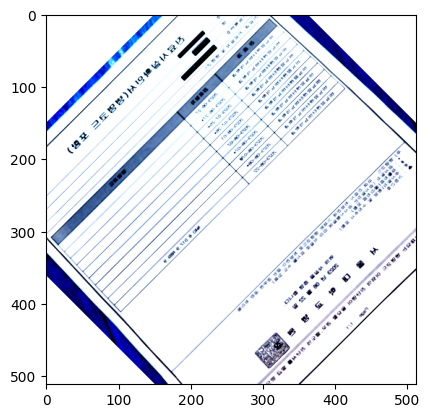

In [54]:
# 저장한 이미지 확인
plt.imshow(tst_img[12345])
plt.show()

In [55]:
tst_df = pd.DataFrame({
    'img' : tst_img,
    'target' : tst_target_list,
    'predict' : tst_preds_list
})

In [56]:
# 맞춘 개수
(tst_df['predict'] == tst_df['target']).sum()

12963

In [57]:
# 틀린 개수
(~(tst_df['predict'] == tst_df['target'])).sum()

1481

In [58]:
tst_df[~(tst_df['predict'] == tst_df['target'])]

,img,target,predict
10,"[[[-1.8781574, -1.247899, -0.07895423], [-1.86...",14,3
29,"[[[0.67343086, 0.8879551, 1.1236601], [0.67343...",3,7
35,"[[[-0.18280679, 0.22268908, 0.844793], [-0.199...",4,14
36,"[[[1.4611695, 1.6757703, 1.9776906], [1.444044...",7,3
53,"[[[1.3926705, 1.5532212, 1.7685403], [1.358421...",7,3
...,...,...,...
14423,"[[[0.7764843, 0.1354368, 0.8930517], [0.776484...",3,7
14431,"[[[0.0, 0.0, 0.20392863], [0.0, 0.0, 0.2039286...",3,7
14435,"[[[1.0, 1.0, 0.8958787], [1.0, 1.0, 0.8958787]...",2,13
14440,"[[[0.0, 0.8329173, 0.0], [0.0, 0.8329173, 0.0]...",4,14


In [70]:
i = pd.read_csv('../datasets_fin/test.csv')
i

,ID,target
0,02d404271e4965fa.jpg,15
1,03648b6855b9f8c1.jpg,10
2,0482c84f6e50fc44.jpg,5
3,05c521f2659c0711.jpg,16
4,0664699c12c8162c.jpg,11
...,...,...
152,e8e8dd06a96f2586.jpg,16
153,e985d6cb79c79810.jpg,4
154,ea379b41d59cec36.jpg,9
155,ebdb6f14d9876caa.jpg,8


In [71]:
# 각 예측의 이미지 id 추가
tst_df['ID'] = list(i['ID']) * 92

In [72]:
tst_df

,img,target,predict,ID
0,"[[[-1.8781574, -1.8256301, -1.5778649], [-1.87...",15,15,02d404271e4965fa.jpg
1,"[[[0.89605266, 1.1855742, 1.4373856], [0.86180...",10,10,03648b6855b9f8c1.jpg
2,"[[[-0.4054286, 0.030112064, 0.46135077], [-0.4...",5,5,0482c84f6e50fc44.jpg
3,"[[[0.21106254, 0.46778712, 0.8622222], [0.1768...",16,16,05c521f2659c0711.jpg
4,"[[[0.5535576, 0.3102241, 0.16505449], [0.57068...",11,11,0664699c12c8162c.jpg
...,...,...,...,...
14439,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",16,16,e8e8dd06a96f2586.jpg
14440,"[[[0.0, 0.8329173, 0.0], [0.0, 0.8329173, 0.0]...",4,14,e985d6cb79c79810.jpg
14441,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",9,9,ea379b41d59cec36.jpg
14442,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.2071282...",8,8,ebdb6f14d9876caa.jpg


In [73]:
def get_item(idx):
    image, target, predict, name = tst_df.loc[idx,]
    img = np.array(Image.open(os.path.join("../datasets_fin/train/", name)))

    # img = trn_transform(image=img)['image']
    return img, target, name, predict, image

In [74]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('target')

target
7     416
3     353
14    205
4     134
12    130
11     96
13     48
15     33
16     22
5      14
1      10
10     10
2       9
6       1
Name: count, dtype: int64

In [75]:
tst_df[(tst_df['predict'] != tst_df['target'])].value_counts('predict')

predict
3     387
7     356
14    202
13    155
6     151
12     55
10     42
4      34
11     31
0      20
8      16
15     16
2      10
16      5
9       1
Name: count, dtype: int64

In [76]:
qw = tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == 4)]
qw

,img,target,predict,ID
35,"[[[-0.18280679, 0.22268908, 0.844793], [-0.199...",4,14,2db10d90789ed7e6.jpg
91,"[[[-1.2959157, -0.897759, 1.1759477], [-1.2787...",4,14,654e10bb8ec38099.jpg
192,"[[[-0.18280679, 0.22268908, 0.844793], [-0.199...",4,14,2db10d90789ed7e6.jpg
876,"[[[0.2281873, 0.46778712, 0.6879303], [0.22818...",4,14,654e10bb8ec38099.jpg
960,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",4,14,16176cca20eed3c8.jpg
...,...,...,...,...
14322,"[[[0.46127754, 0.67712903, 1.0], [0.46127754, ...",4,14,2db10d90789ed7e6.jpg
14375,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",4,14,60d372fb5e69fafe.jpg
14382,"[[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0,...",4,14,81dbdb42bedcde5e.jpg
14400,"[[[0.9673866, 1.0, 1.0], [0.9673866, 1.0, 1.0]...",4,7,b92152203e68a586.jpg


In [77]:
qw.value_counts('predict')

predict
14    101
7      10
3       8
15      5
6       3
13      2
16      2
0       1
9       1
11      1
Name: count, dtype: int64

In [78]:
tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == 12)].index

Index([   67,   101,   189,   224,   258,   538,   817,   849,   852,  1166,
       ...
       13883, 13917, 14005, 14037, 14040, 14111, 14197, 14231, 14351, 14388],
      dtype='int64', length=130)

In [1]:
# # target과 predict가 일치하지 않는 이미지 시각화, target별로 확인
# check_target = 12
# for idx in tst_df[(tst_df['predict'] != tst_df['target'])&(tst_df['target'] == check_target)].index:
#     img, target, name, predict, image = get_item(idx)
#     print(img.shape, name, target, predict)
#     # plt.imshow(img) #원본 이미지
#     # plt.show()
#     plt.imshow(image) #학습에 사용된 이미지
#     plt.show()
#     # print(idx)

In [112]:
qw = tst_df[tst_df['target'] == 13]
qw

,img,target,predict,ID
17,"[[[-1.6555356, -1.545518, -1.4035729], [-1.724...",13,13,149c8444ae80d630.jpg
28,"[[[1.7522904, 1.9558823, 2.1519825], [1.735165...",13,13,233685659ef1ed84.jpg
81,"[[[0.108314015, 0.3452381, 0.56592596], [0.142...",13,13,590a4befbe2db3cc.jpg
83,"[[[0.36518532, 0.80042017, 1.1585186], [0.3823...",13,13,5be46f4d1470b120.jpg
96,"[[[0.8618032, 1.1330532, 1.4896731], [0.878927...",13,13,81e5282c3c19a13b.jpg
...,...,...,...,...
14368,"[[[0.0, 0.80398476, 0.7526777], [0.0, 0.803984...",13,7,590a4befbe2db3cc.jpg
14370,"[[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.1174487...",13,12,5be46f4d1470b120.jpg
14383,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.5157264...",13,13,81e5282c3c19a13b.jpg
14392,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",13,7,b0ab48967aaabefe.jpg


In [111]:
(qw['predict'] != qw['target']).sum()

126